In [38]:

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from torchvision.transforms import transforms
from tqdm import tqdm

import model_architectures.model_factory as model_factory
from train_model import LitDataModule, DEVICE
from geopy.distance import distance


In [54]:
datamodule = LitDataModule("data/Europe", 32, num_workers=0)
datamodule.setup("test")
test_dataloader = datamodule.test_dataloader()

data/Europe
32
id      int64
x     float64
y     float64
dtype: object


In [170]:
model_dict = torch.load("models/model_93.pth")
model = model_factory.get_model("ResNet18", classes=2)
model.load_state_dict(model_dict)
model = model.to(DEVICE)

In [146]:
min_x, min_y, max_x, max_y, = -9.277194, 35.226374, 30.923247, 58.888745

In [147]:
print("approx area of a rectangular region")
distance([min_x, min_y], [max_x, max_y]).km * distance([min_x, max_y], [max_x, min_y]).km / 2, "km^2"

approx area of a rectangular region


(13086002.899370035, 'km^2')

In [148]:
x = 500/8080464 
x

6.187763474968764e-05

In [137]:
# coefficient relative to area
score_coef = 13086002 * x
score_coef

809.730852089682

In [138]:
score_fn = lambda x : 5000*np.exp(-x/score_coef) 
# according to https://www.reddit.com/r/geoguessr/comments/7fon8u/geomath_deriving_the_geoguessr_point_formula/
# since the post does not specify what units are used, but is centered around america, i will use miles


1454.2054237342095

In [171]:
model.eval()
crit = torch.nn.MSELoss()
distances = []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images = images.to(DEVICE)
        # pred_labels = (torch.fft.irfftn(model(images), 128, dim=1)[:,:2]).cpu().numpy()
        pred_labels = (torch.sigmoid(model(images))).cpu().numpy()
        
        
        # for i in pred_labels:
        pred_labels[:,0] = datamodule.itransform_x(pred_labels[:,0])
        pred_labels[:,1] = datamodule.itransform_y(pred_labels[:,1])

        labels[:,0] = datamodule.itransform_x(labels[:,0])
        labels[:,1] = datamodule.itransform_y(labels[:,1])

        for pred, true in zip(pred_labels, labels):
            distances.append(distance(pred, true).miles)


        # break
np.mean(distances) 

100%|██████████| 192/192 [00:24<00:00,  7.86it/s]


626.376773313918

In [172]:
np.min(distances), np.max(distances)

(5.936306326916578, 2215.8532112086423)

In [248]:
import scipy.stats as stats
import scipy
from pprint import pprint
desc = stats.describe(distances)
print("minmax", *desc.minmax)
print("mean", desc.mean)
print("std", np.sqrt(desc.variance)) 

minmax 5.936306326916578 2215.8532112086423
mean 626.376773313918
std 371.6273078561512


In [173]:
scores = np.array([score_fn(i) for i in distances])

In [174]:
print("average score")
np.mean(np.array(scores)) * 5

average score


12671.625717299732

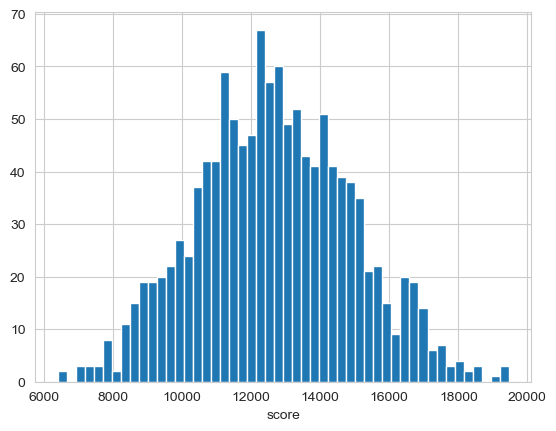

In [238]:
plt.hist(scores[:len(scores) - len(scores)%5].reshape(-1, 5).sum(axis=1), bins=50)
plt.xlabel("score")
plt.show()

note that average score on europe map in geoguessr is 12000

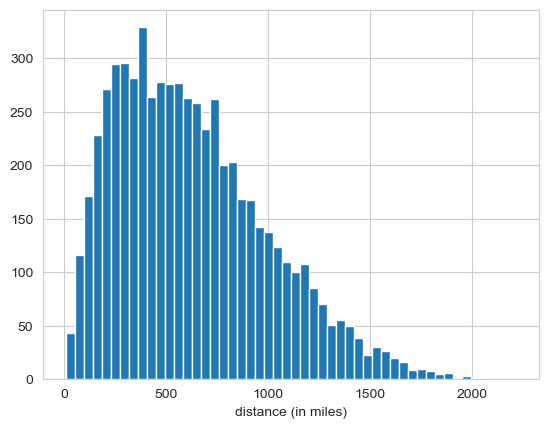

In [240]:
plt.hist([i for i in distances], bins=50)
plt.xlabel("distance (in miles)")
plt.show()

In [177]:
model.eval()
predicted = []
correct = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(DEVICE)
        # pred_labels = (torch.fft.irfftn(model(images), 128, dim=1)[:,:2]).cpu().numpy()
        pred_labels = (torch.sigmoid(model(images))).cpu().numpy()
        labels = labels.cpu().numpy()
        pred_labels[:,0] = datamodule.itransform_x(pred_labels[:,0])
        pred_labels[:,1] = datamodule.itransform_y(pred_labels[:,1])

        labels[:,0] = datamodule.itransform_x(labels[:,0])
        labels[:,1] = datamodule.itransform_y(labels[:,1])
        
        break
predicted = pred_labels
correct = labels

In [184]:
import seaborn as sns

In [231]:
n_images = 10
colors = sns.color_palette("hls", n_images).as_hex()

In [232]:
lon = []
lat = []
marker_colors = []
markers = []
shapes = ["circle", "square"] * n_images
for i, (pred, label) in enumerate(zip(predicted, correct)):
    if i == n_images: break
    lon += [label[0], pred[0]]
    lat += [label[1], pred[1]]
    marker_colors += [colors[i]] * 2
    markers += [dict(
        size=120,
        line=dict(
            color='green',
            width=12
        )),
        dict(
            size=120,
            line=dict(
                color='red',
                width=12
            ))]
    



array([ 6.567339 , 15.910773 , 22.028706 ,  8.927667 ,  4.3388033,
       15.765147 , -2.4908857, -1.5400534, 18.89584  , 16.388393 ,
        9.521821 , 10.564143 , 29.13002  , -0.6801796, 23.584736 ,
       -2.8746753, 29.126225 ,  4.881583 , 18.346478 , 26.844498 ,
       21.005802 ,  6.667263 , 10.4313345, 24.517487 ,  5.1759615,
        4.8391867, 15.246352 ,  8.95659  , 18.267258 , 11.788196 ,
       22.244488 , 12.628322 ], dtype=float32)

In [249]:
import plotly.graph_objects as go

i = 0
# for pred, label in zip(predicted, correct):
fig = go.Figure()
fig.add_scattergeo(    lon = correct[:n_images, 0],
                       lat = correct[:n_images, 1],
                       marker=dict(
                       size=8,
                       line=dict(
                           color='green',
                           width=2
                       )),
                       mode = 'markers',
                       marker_color = colors,
                       )
fig.add_scattergeo(    lon = predicted[:n_images, 0],
                       lat = predicted[:n_images, 1],
                       marker=dict(
                           color='green',
                           size=8,
                           line=dict(
                               color='red',
                               width=2
                           )),
                       mode = 'markers',
                       marker_color = colors,
                       )
for i in range(n_images):
    fig.add_trace(go.Scattergeo(
        lon = [predicted[i][0], correct[i][0]],
        lat = [predicted[i][1], correct[i][1]],
        mode = 'lines',
        line=dict(color=colors[i], width=2),
    ))
    
fig.update_layout(

    # title = 'Most trafficked US airports<br>(Hover for airport names)',
    geo_scope='europe',
)
fig.show()

In [179]:
import shap

batch = next(iter(test_dataloader))
images, _ = batch
# images = images.view(-1, 1, 28, 28)
# images.to(device=DEVICE)
images = images.to(device=DEVICE)
test_images= images[:20]

e = shap.DeepExplainer(model.to(device=DEVICE), images)
shap_values = e.shap_values(test_images)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [234]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]

In [235]:
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.255],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.255]
)

# Apply inverse normalization to your tensor
inv_normalized_tensor = inv_normalize(test_images.cpu())

In [236]:
_ = list(
    *zip(
        *zip(
            [
                "px:{:2f} cx:{:2f}".format(p[0], c[0]),
                "py:{:2f} cy:{:2f}".format(p[1], c[1])
                # c[0],
                # c[1]

            ]
            for p, c in zip(predicted[:20], correct[:20])
        )
    )
)
# labels_for_plotting = list(zip(*_))
labels_for_plotting = np.array(_)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

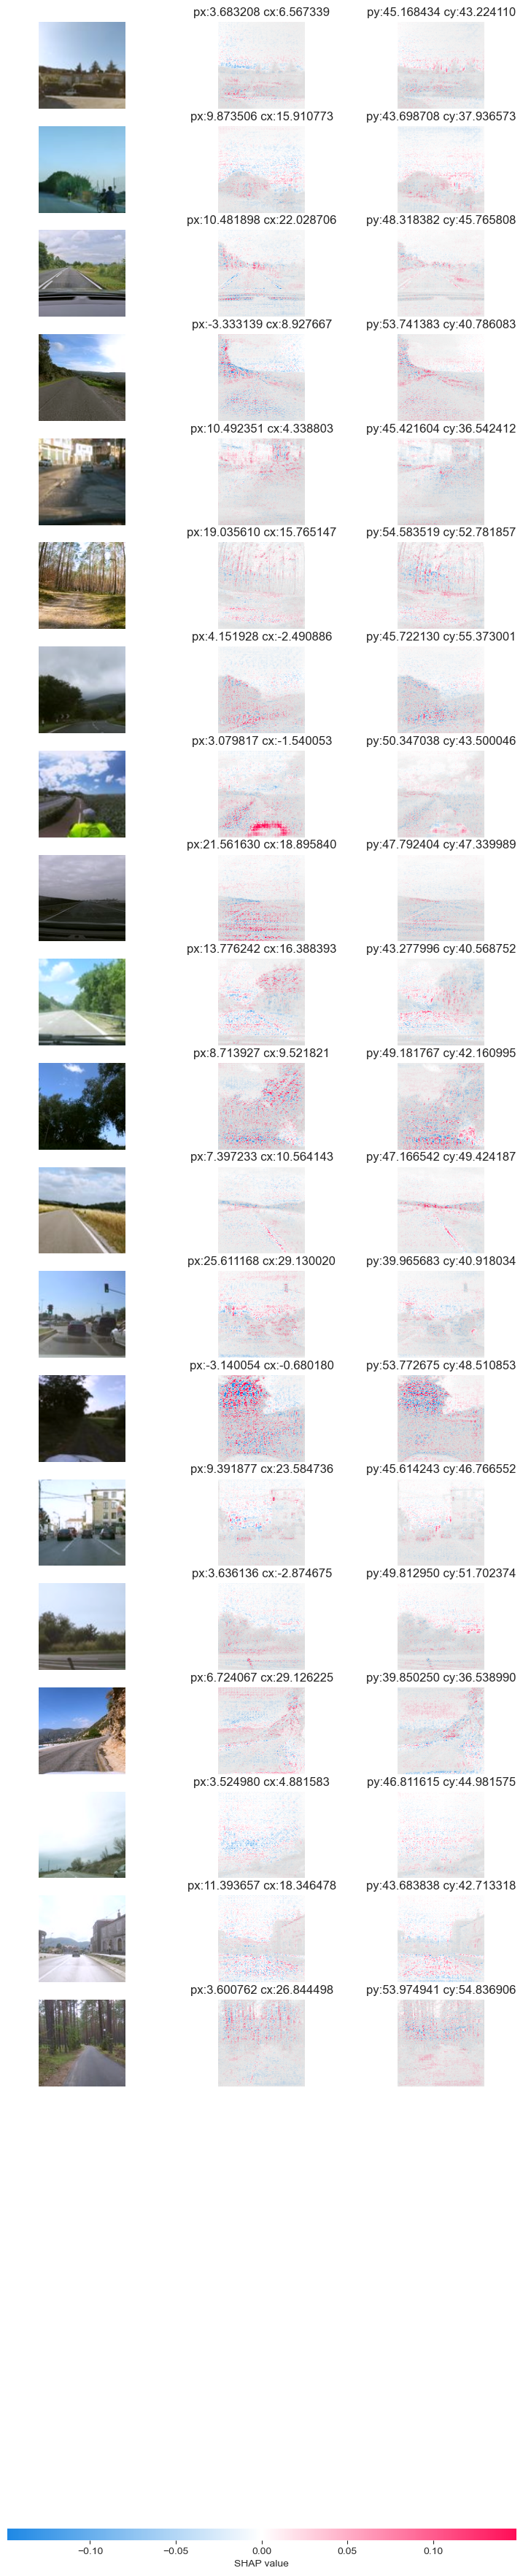

In [237]:
shap.image_plot(shap_numpy, np.swapaxes(np.swapaxes(inv_normalize(test_images.cpu()).numpy(), 2, 3), 1, 3), labels_for_plotting)

In [4]:
from playsound import playsound

    

In [200]:
sample = torch.from_numpy(np.array([[1,1], [1,1], [2,2], [1,0]]))

In [60]:
torch.sigmoid(torch.from_numpy(np.array([[1,1], [100,100]])))

tensor([[0.7311, 0.7311],
        [1.0000, 1.0000]])

In [225]:
torch.cat([torch.linswpace(0,1, 20), torch.linspace(0,1, 20)])

tensor([0.0000, 0.0526, 0.1053, 0.1579, 0.2105, 0.2632, 0.3158, 0.3684, 0.4211,
        0.4737, 0.5263, 0.5789, 0.6316, 0.6842, 0.7368, 0.7895, 0.8421, 0.8947,
        0.9474, 1.0000, 0.0000, 0.0526, 0.1053, 0.1579, 0.2105, 0.2632, 0.3158,
        0.3684, 0.4211, 0.4737, 0.5263, 0.5789, 0.6316, 0.6842, 0.7368, 0.7895,
        0.8421, 0.8947, 0.9474, 1.0000])

In [246]:
torch.random.manual_seed(42)
sample = torch.rand((8,2))
sample

tensor([[0.8823, 0.9150],
        [0.3829, 0.9593],
        [0.3904, 0.6009],
        [0.2566, 0.7936],
        [0.9408, 0.1332],
        [0.9346, 0.5936],
        [0.8694, 0.5677],
        [0.7411, 0.4294]])

In [261]:
torch.fft.irfftn(torch.fft.rfftn(sample, 40, dim=1, ), 40, dim=1, )[:, :2]

tensor([[0.8823, 0.9150],
        [0.3829, 0.9593],
        [0.3904, 0.6009],
        [0.2566, 0.7936],
        [0.9408, 0.1332],
        [0.9346, 0.5936],
        [0.8694, 0.5677],
        [0.7411, 0.4294]])

In [255]:
sample.shape

torch.Size([8, 2])

In [259]:
fft_sample = torch.fft.rfftn(sample, 40, dim=1)
fft_sample

tensor([[ 1.7973+0.0000j,  1.7860-0.1431j,  1.7525-0.2828j,  1.6975-0.4154j,
          1.6225-0.5378j,  1.5293-0.6470j,  1.4201-0.7403j,  1.2977-0.8153j,
          1.1650-0.8702j,  1.0254-0.9037j,  0.8823-0.9150j,  0.7391-0.9037j,
          0.5995-0.8702j,  0.4669-0.8153j,  0.3444-0.7403j,  0.2353-0.6470j,
          0.1420-0.5378j,  0.0670-0.4154j,  0.0120-0.2828j, -0.0215-0.1431j,
         -0.0327+0.0000j],
        [ 1.3422+0.0000j,  1.3304-0.1501j,  1.2952-0.2964j,  1.2376-0.4355j,
          1.1590-0.5639j,  1.0612-0.6783j,  0.9467-0.7761j,  0.8184-0.8547j,
          0.6793-0.9124j,  0.5329-0.9475j,  0.3829-0.9593j,  0.2328-0.9475j,
          0.0864-0.9124j, -0.0527-0.8547j, -0.1810-0.7761j, -0.2955-0.6783j,
         -0.3932-0.5639j, -0.4719-0.4355j, -0.5295-0.2964j, -0.5646-0.1501j,
         -0.5764+0.0000j],
        [ 0.9913+0.0000j,  0.9839-0.0940j,  0.9619-0.1857j,  0.9258-0.2728j,
          0.8766-0.3532j,  0.8153-0.4249j,  0.7436-0.4861j,  0.6632-0.5354j,
          0.5761-0.571

In [260]:
fft_sample.shape

torch.Size([8, 21])

In [214]:
ifftn = torch.fft.irfftn(fft_sample, 40, dim=1, norm="backward")
ifftn.mean(dim=1, keepdim=True)

tensor([[0.0500],
        [0.0500],
        [0.1000],
        [0.0250]])

In [204]:
ifftn = torch.fft.irfftn(fft_sample, 2, dim=1, norm="backward")
ifftn

tensor([[1.7500, 0.2500],
        [1.7500, 0.2500],
        [3.5000, 0.5000],
        [1.0000, 0.0000]])

In [188]:
ifftn

tensor([[1.8870, 0.3827],
        [1.8870, 0.3827]])

In [125]:
torch.fft.ff

TypeError: fft_fftfreq(): argument 'd' (position 2) must be float, not Tensor

In [157]:
np.concatenate([[[1,1], [1,1]], [[1,1], [1,1]]])

array([[1, 1],
       [1, 1],
       [1, 1],
       [1, 1]])

In [169]:
import pandas as pd

pd.DataFrame(pred_labels, range(0,2*len(pred_labels), 2))

,0,1
0,0.008364,44.855507
2,10.898475,42.877384
4,11.448407,52.859665
6,-1.354056,53.029686
8,10.532666,43.394585
10,9.289937,52.248692
12,3.889965,47.509933
14,2.188312,51.151443
16,5.332611,47.245464
18,17.916481,47.150055


array([[ 8.3637238e-03,  4.4855507e+01],
       [ 1.0898475e+01,  4.2877384e+01],
       [ 1.1448407e+01,  5.2859665e+01],
       [-1.3540559e+00,  5.3029686e+01],
       [ 1.0532666e+01,  4.3394585e+01],
       [ 9.2899370e+00,  5.2248692e+01],
       [ 3.8899651e+00,  4.7509933e+01],
       [ 2.1883116e+00,  5.1151443e+01],
       [ 5.3326111e+00,  4.7245464e+01],
       [ 1.7916481e+01,  4.7150055e+01],
       [ 5.2053013e+00,  4.8678604e+01],
       [ 9.9254065e+00,  4.8158459e+01],
       [ 1.7380260e+01,  4.4729507e+01],
       [-6.9797421e-01,  5.1339516e+01],
       [ 1.1031398e+01,  4.6174568e+01],
       [ 5.9429359e-01,  5.0202305e+01],
       [ 5.5264959e+00,  3.8140324e+01],
       [ 7.5289888e+00,  4.8677242e+01],
       [ 8.5884085e+00,  4.5130524e+01],
       [ 5.4711428e+00,  5.4156960e+01],
       [ 6.9244642e+00,  5.0545662e+01],
       [ 5.3124056e+00,  4.5249603e+01],
       [ 6.6700506e+00,  5.2981441e+01],
       [ 4.7701836e+00,  4.5128872e+01],
       [ 2.10538